# Autoencoders

In this notebook we'll try something more advanced - we are going to learn about a special type of a neural network called Autoencoder. Lets first make the imports:

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Activation, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import math
import random

Using TensorFlow backend.


## MNIST Dataset

We will again use our well known MNIST dataset, so lets load it first:

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

We can take a look on how the images look like, e.g. from the testing set. Each image is 28 x 28 pixels size

In [3]:
x_train.shape

(60000, 28, 28)

Lets draw some images:

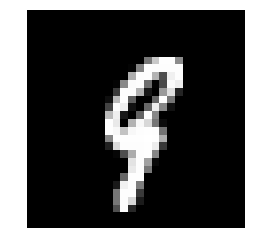

Image label: 9


In [4]:
image_size = 28

image_num = random.randint(0, len(x_train))
img = x_train[image_num]

img = img.reshape(image_size, image_size)

plt.figure()
plt.axis('off')
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

print("Image label: {}".format(y_train[image_num]))

## Autoencoders

Autoencoders are very interesitng variation of a neural network. In a typical neural network, we have some input data features, based on which we want to predict the labels. So a typical neural network does an aproximation of some function f:

$$
f(x) = y
$$

All of the examples we have shown you before actually use this kind of architecture and do predictions.

Autoencoder is different, with autoencoder you are actually trying to predict the same data as you got on the input:

$$
f(x) = x
$$

Why would you do such a thing? Well let's first look at the autoencoder typical architecture. 

```
               (x)                       (x)
        
               (x)          (x)          (x)
        
input =======> (x) =======> (x) =======> (x) =======> input'
        
               (x)          (x)          (x)
        
               (x)                       (x)
           
             encoder    hidden state   decoder
```

There couple important things here - as explained earlier, during the training the autoencoder is using the same input and output data - it's trying to predict the input from itself. This is done by composing two neural networks - an encoder network and decoder network. Typically the output of the encoder has lower dimensionality than the input itself - it is in some form a compressed representation of the input. But you can also view this as a representation of the most important part of the input, that can be used to reconstruct it back.

You can use different network architectures for both encoder and decoder. For example for image tasks, convolutional layers are common, for sequence based tasks (text processing and similar) recurent layers are typically used.

What you can use autoencoder for some very specific tasks, for example:
- create a compressed representation of the input, that can be used to reconstruct it (though this is a very bad compression algorithm, as it can compress only very specific data)
- because the autoencoder learns the most important part of the input, it can be actually used for removing the noise from the data - e.g. denoising the images
- autoencoders can be used for detecting anomalies in the data, such as frauds in financial transactions, or iot sensor malfunction. This is because they can learn how "normal" data look like, and if the predicted output differs from the input, we can consider it as anomaly.

As an example for autoencoder we will show how to denoise images from MNIST.

We will use already loaded data, we just need to reshape it back to 28 x 28 pixels, as we are going to use convolutional layers this time

In [5]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1]) / 255
x_test = np.reshape(x_test, [-1, image_size, image_size, 1]) / 255

In [6]:
x_train.shape

(60000, 28, 28, 1)

Now we are going to add some random noise to the images

In [7]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Now we have a transformed dataset, lets draw some samples:

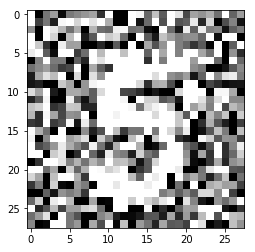

Image labels: 5


In [8]:
image_index = random.randint(0, len(x_train_noisy))
img = x_train_noisy[image_index]
img.shape
img_plt = img.reshape(image_size, image_size
                    )
img_plt = (img_plt * 255).astype(np.uint8)

plt.imshow(img_plt, interpolation='none', cmap='gray')
plt.show()

print("Image labels: {}".format(y_train[image_index]))

We are going to create an encoder with convolutional layers that are going to create a hidden representation of the image.

In [9]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

Note here the convolutional layers that are transforming the image to smaller and smaller sizes - you will need to code the oposite transformation in the decoder.

In [10]:
# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

x = Conv2D(filters=32,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
x = Conv2D(filters=64,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [11]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


As we see, the output of the encoder is just 16 values - much less than original 784. Now lets create a decoder from this

In [12]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

Your turn now, define the decoder convolutional layers - they have similar parameters as the two layers above, just you need to use Conv2DTranspose layer instead of Conv2D and reverse the filter numbers:

In [13]:
x = Conv2DTranspose(filters=64,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
x = Conv2DTranspose(filters=32,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# x = Conv2DTranspose(filters=64,
#                         kernel_size=kernel_size,
#                         strides=2,
#                         activation='relu',
#                         padding='same')(x)
# x = Conv2DTranspose(filters=32,
#                         kernel_size=kernel_size,
#                         strides=2,
#                         activation='relu',
#                         padding='same')(x)

In [14]:
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

Train the model (we can also show a summary)

In [15]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=2,
                batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0661 - val_loss: 0.0376
Epoch 2/2
60000/60000 [==============================] - 59s 985us/step - loss: 0.0277 - val_loss: 0.0223


And make predictions on the whole test set

In [16]:
x_decoded = autoencoder.predict(x_test_noisy)

We can now show the picture after denoising

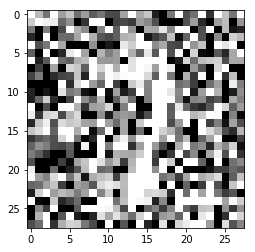

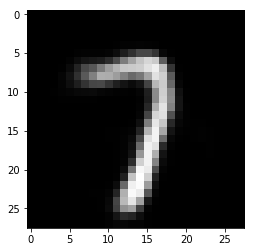

In [17]:
index = random.randint(0, len(x_test_noisy))
img = x_test_noisy[index]
img_plt = img.reshape(image_size, image_size)
img_plt = (img_plt * 255).astype(np.uint8)

plt.imshow(img_plt, interpolation='none', cmap='gray')
plt.show()

img = x_decoded[index]
img_plt = img.reshape(image_size, image_size)
img_plt = (img_plt * 255).astype(np.uint8)

plt.imshow(img_plt, interpolation='none', cmap='gray')
plt.show()